# 2.3. Comparison using the whole Exoplanet Archive (8 params)

Equivalent of `2_1_comparison_whole_archive_runs.ipynb`, but now uses the 8x8 dataset.  
This notebook includes some data analysis with few dirty sections...

In [3]:
import os
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from knnxkde import KNNxKDE
from utils import normalization, renormalization
from utils import convolution_TLG2020_fix_incl
from GAIN.gain import gain

## 0. Prepare matrix

- Load data
- Remove mass if not observed mass
- Select subset of feature for imputation
- Transform log
- Print feature statistics and plot pairplot

In [4]:
original_df = pd.read_csv('data/exoplanets2023.csv')

my_df = original_df.copy()
for n in range(len(my_df)):
    if my_df.loc[n, 'pl_bmassprov'] == 'Msini':
        my_df.loc[n, 'pl_bmassj'] = np.nan
    if my_df.loc[n, 'pl_orbeccen']<0.0:
        my_df.loc[n, 'pl_orbeccen'] = np.nan  # Remove the 3 suspicious values 

In [5]:
ALL_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_orbincl',
    'pl_eqt',
    'st_mass',
    'st_met',
    'st_age',
    'sy_snum',
    'sy_pnum'
]

TLG2020_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_eqt',
    'st_mass',
    'sy_pnum',
]

NEW_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_eqt',
    'st_mass',
    'st_met',
    'sy_pnum',
]

In [6]:
for f in ALL_FEATURES:
    mini = np.nanmin(my_df[f])
    maxi = np.nanmax(my_df[f])
    mr = np.mean(np.isnan(my_df[f]))  # miss rate
    print(f'{f} -> min={mini}, max={maxi}, mr={mr:0.2%}')

pl_radj -> min=0.026, max=6.9, mr=30.39%
pl_bmassj -> min=6e-05, max=31.0, mr=72.84%
pl_orbper -> min=0.09070629, max=402000000.0, mr=3.71%
pl_orbeccen -> min=0.0, max=0.95, mr=70.20%
pl_orbincl -> min=7.7, max=176.092, mr=71.38%
pl_eqt -> min=48.37660541, max=7719.403614, mr=13.52%
st_mass -> min=0.01, max=10.94, mr=0.51%
st_met -> min=-1.0, max=0.56, mr=10.15%
st_age -> min=0.001, max=14.9, mr=26.49%
sy_snum -> min=1, max=4, mr=0.00%
sy_pnum -> min=1, max=8, mr=0.00%


In [7]:
X = np.array(my_df[NEW_FEATURES])
X[:, [0, 1, 2, 4, 5]] = np.log(X[:, [0, 1, 2, 4, 5]])

<Figure size 432x288 with 0 Axes>

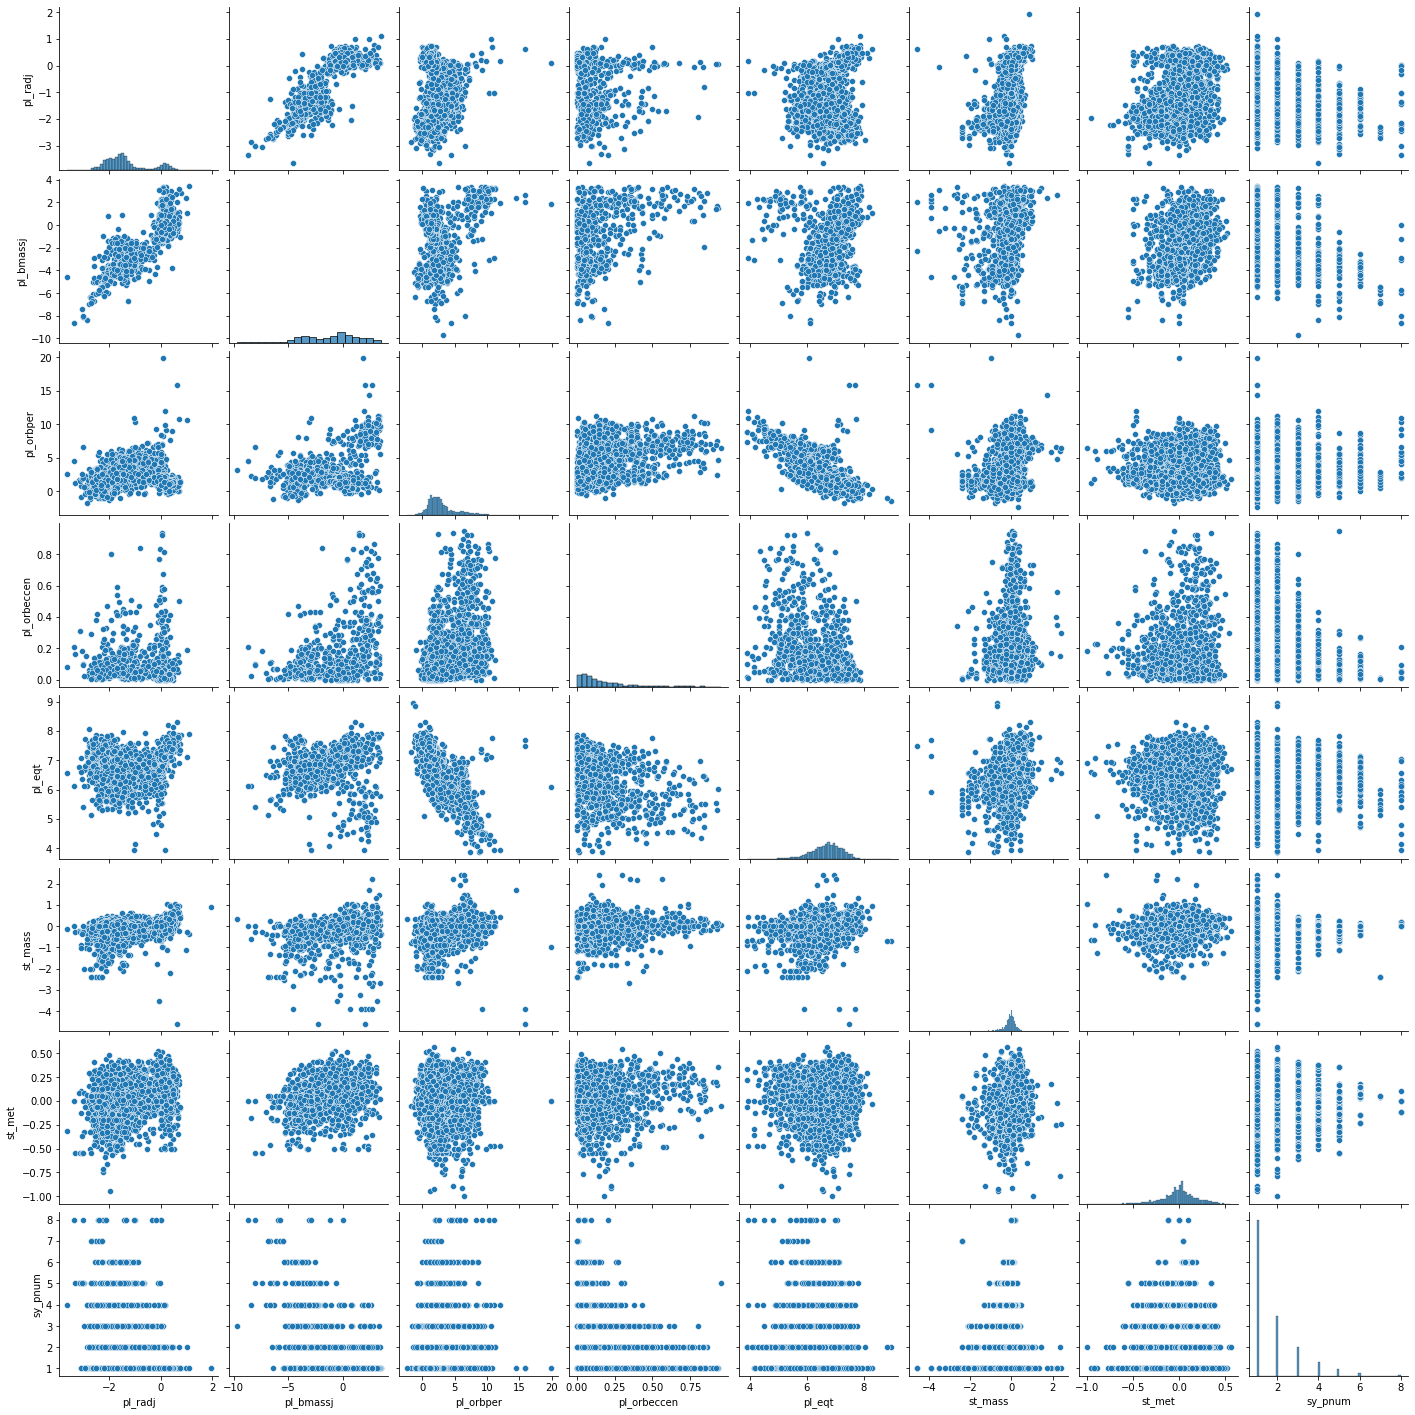

In [8]:
X_df = pd.DataFrame(X, columns=NEW_FEATURES)
plt.figure()
sns.pairplot(X_df)
plt.show()

## A. Transit Case

Just for the $k$NN$\times$KDE 

In [7]:
DICT_OBSERVED_MASS_NAME_ID = dict()  # store the name and row number of planets with observed mass
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASSES = len(DICT_OBSERVED_MASS_NAME_ID)

In [13]:
MY_TAU = 1.0 / 50.0  # for kNNxKDE (before 1.0 / 50.0)
MY_NB_NEIGH = 20  # for kNNxKDE (before 20)

In [14]:
imputed_masses = {
    'knnxkde': dict(),  
}

N, D = X.shape

In [11]:
for i1, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    print(f'{i1+1}/{NB_OBSERVED_MASSES}... {cur_name}                      ', end='\r')
    if ((i1+1)%100)==0:
        print(f'                                           ', end='\r')
        print(f'{i1+1}/{NB_OBSERVED_MASSES} -> {time.strftime("%H:%M:%S", time.localtime())}')
    miss_data = np.copy(X)
    miss_data[cur_idx, 1] = np.nan  # Transit case: hide the mass
    norm_miss_data, norm_params = normalization(miss_data)
    
    knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
    norm_imputed_data = knnxkde.impute_mean(norm_miss_data, nb_draws=1000, chosen_subset=[0, 1, 2, 4, 5, 7])
    renorm_imputed_data = renormalization(norm_imputed_data, norm_params)
    imputed_masses['knnxkde'][cur_name] = np.exp(renorm_imputed_data[cur_idx, 1])

100/1426 -> 11:25:36                                        
200/1426 -> 11:31:54                         
300/1426 -> 11:38:18                           
400/1426 -> 11:44:41                           
500/1426 -> 11:51:27                            
600/1426 -> 11:57:36                                  
700/1426 -> 12:03:24                           
800/1426 -> 12:09:05                          
900/1426 -> 12:14:48                          
1000/1426 -> 12:20:30                                    
1100/1426 -> 12:26:13                                      
1200/1426 -> 12:31:56                          
1300/1426 -> 12:37:39                                       
1400/1426 -> 12:43:26                                           


In [12]:
save_dir = f'results_and_figures/2_comp_whole_archive'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
#with open(f'{save_dir}/transit_case_masses_8params_nbn20_subset6.pkl', 'wb') as f:
#    pickle.dump(imputed_masses, f)

Reload the imputed masses, compute error $\epsilon$, and plot results

In [15]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/transit_case_masses_8params_nbn20_subset6.pkl', 'rb') as f:
    imputed_masses = pickle.load(f)

In [16]:
np_masses = np.zeros((2, NB_OBSERVED_MASSES))
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    np_masses[0, i] = imputed_masses['knnxkde'][cur_name]

In [17]:
np_eps = np.zeros(NB_OBSERVED_MASSES)
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    true_mass = my_df.iloc[cur_idx]['pl_bmassj']
    np_eps[i] = np.log(true_mass) - np.log(imputed_masses['knnxkde'][cur_name])
    np_masses[1, i] = true_mass

In [19]:
print(np.sqrt(np.mean(np_eps ** 2.0)))  # Slightly better than before (1.51)

1.5019806150405206


Compute the epsilon over 10 bins

In [20]:
MJ = 317.8  # in Earth masses
list_thresh = np.geomspace(1e-1, 1e4, num=11)
np_eps_thresh = np.zeros(len(list_thresh)-1)

for n in range(len(list_thresh)-1):
    thresh1 = list_thresh[n]
    thresh2 = list_thresh[n+1]
    mask1 = (np_masses[1] * MJ) > thresh1
    mask2 = (np_masses[1] * MJ) < thresh2
    mask = np.logical_and(mask1, mask2)
    print(f"{n} -> {thresh1:.2e} ~ {thresh2:.2e} | Count = {str(np.sum(mask)).rjust(3, ' ')}", end='')
    np_eps_thresh[n] = np.sqrt(np.mean((np.log(np_masses[1]) - np.log(np_masses[0]))[mask] ** 2.0))
    print(f'  => Eps = {np_eps_thresh[n]:.4f}')
print(f'Everyone | Count = {np_masses[1].shape[0]}', end='')
print(f'  => {np.sqrt(np.mean((np.log(np_masses[1]) - np.log(np_masses[0])) ** 2.0)):.4f}')

0 -> 1.00e-01 ~ 3.16e-01 | Count =   3  => Eps = 1.5117
1 -> 3.16e-01 ~ 1.00e+00 | Count =  17  => Eps = 1.7248
2 -> 1.00e+00 ~ 3.16e+00 | Count =  58  => Eps = 1.1724
3 -> 3.16e+00 ~ 1.00e+01 | Count = 207  => Eps = 0.9972
4 -> 1.00e+01 ~ 3.16e+01 | Count = 186  => Eps = 0.8784
5 -> 3.16e+01 ~ 1.00e+02 | Count = 138  => Eps = 1.4252
6 -> 1.00e+02 ~ 3.16e+02 | Count = 297  => Eps = 1.0978
7 -> 3.16e+02 ~ 1.00e+03 | Count = 243  => Eps = 1.2376
8 -> 1.00e+03 ~ 3.16e+03 | Count = 160  => Eps = 2.1470
9 -> 3.16e+03 ~ 1.00e+04 | Count = 113  => Eps = 2.8587
Everyone | Count = 1426  => 1.5020


Obtain the planets in the test set of TLG2020 for comparison.  
Then plot the results like before

In [15]:
rv_dists = np.load('data/mdists__mask[001111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')
transit_dists = np.load('data/mdists__mask[101111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')

In [16]:
colnames = ['idx', 'pl_name', 'pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']
all_planets = pd.read_csv('data/NEA_radmasstpersmasspnum.csv', names=colnames, sep=',', skiprows=1)
rs = np.random.RandomState(12345)
dataidx = rs.permutation(all_planets.shape[0])  # it's the very same, I have checked
train_names = all_planets['pl_name'][dataidx[0:400]]
test_names = all_planets['pl_name'][dataidx[400:]]
true_masses_550 = np.array(all_planets.iloc[dataidx[400:]]['pl_bmassj'])
true_radii_550 = np.array(all_planets.iloc[dataidx[400:]]['pl_radj'])

In [23]:
bins = 500  # Reproduce TLG2020 epsilon results
logbins = np.logspace(np.log10(0.0001), np.log10(100.0), num=bins)  # in M_J

tnet_mass = []
for p in range(transit_dists.shape[0]):
    r = np.histogram(transit_dists[p, :, 1], bins=logbins, density=False)
    xv = (r[1][:-1] + r[1][1:]) / 2.0
    tnet_mass.append(xv[np.argmax(r[0])])
transit_masses_tlg2020 = np.array(tnet_mass)

In [24]:
mask_tlg2020 = np.zeros(NB_OBSERVED_MASSES, dtype='bool')
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    if cur_name in list(test_names):
        mask_tlg2020[i] = True

In [25]:
np_eps_tlg2020 = np.zeros((2, 150))
for i, pl_name in enumerate(test_names):
    if pl_name in DICT_OBSERVED_MASS_NAME_ID:
        cur_idx = DICT_OBSERVED_MASS_NAME_ID[pl_name]
        true_mass = my_df.iloc[cur_idx]['pl_bmassj']
        np_eps_tlg2020[0, i] = np.log(true_mass) - np.log(imputed_masses['knnxkde'][pl_name])
        np_eps_tlg2020[1, i] = np.log(true_mass) - np.log(transit_masses_tlg2020[i])
    else:  # 4 planets were in the dataset of TLG2020 but not in the new dataset
        print(pl_name)
        np_eps_tlg2020[:, i] = np.nan

KOI-55 c
K2-239 d
K2-240 b
2MASS J21402931+1625183 A b


In [26]:
print(np.sqrt(np.nanmean(np_eps_tlg2020 ** 2.0, axis=1)))  # 0.840 slightly better than before 0.846

[0.83957557 0.92769176]


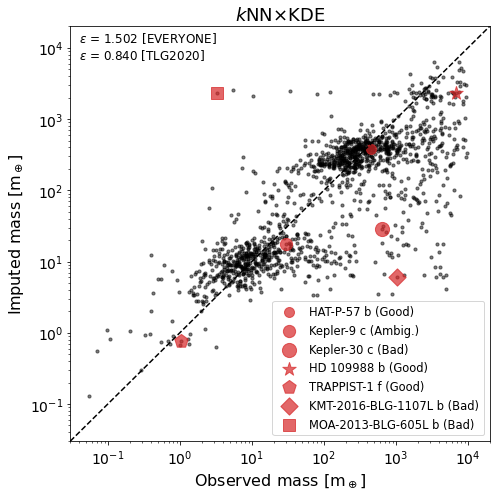

In [24]:
MJ = 317.8  # in Earth masses
MIN_MASS, MAX_MASS = 3e-2, 2e4  # 3e-1, 1.3e4

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(np_masses[1]*MJ, np_masses[0]*MJ, c='black', s=10, alpha=0.5)

idx1, idx2, idx3 = 144, 881, 713  # HAT-P-57 b (GOOD), Kepler-277 c (AMBIGUOUS), Kepler-30 c (BAD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
label3 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx3]
ax.scatter(np_masses[1][idx1]*MJ, np_masses[0][idx1]*MJ, c='C3', s=100, alpha=0.7, label=label1+' (Good)')
ax.scatter(np_masses[1][idx2]*MJ, np_masses[0][idx2]*MJ, c='C3', s=150, alpha=0.7, label=label2+' (Ambig.)')
ax.scatter(np_masses[1][idx3]*MJ, np_masses[0][idx3]*MJ, c='C3', s=200, alpha=0.7, label=label3+' (Bad)')

idx1, idx2 = 238, 1211  # HD 109988 (NEW GOOD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
ax.scatter(np_masses[1][idx1]*MJ, np_masses[0][idx1]*MJ, c='C3', marker='*', s=200, alpha=0.7, label=label1+' (Good)')
ax.scatter(np_masses[1][idx2]*MJ, np_masses[0][idx2]*MJ, c='C3', marker='p', s=200, alpha=0.7, label=label2+' (Good)')

idx1, idx2 = 515, 929  # KMT-2016-BLG-1107L b and MOA-2013-BLG-605L b (both VERY BAD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
ax.scatter(np_masses[1][idx1]*MJ, np_masses[0][idx1]*MJ, c='C3', marker='D', s=150, alpha=0.7, label=label1+' (Bad)')
ax.scatter(np_masses[1][idx2]*MJ, np_masses[0][idx2]*MJ, c='C3', marker='s', s=150, alpha=0.7, label=label2+' (Bad)')

my_txt = f'$\epsilon$ = {np.sqrt(np.mean(np_eps ** 2.0)):.3f} [EVERYONE]\n'
my_txt += f'$\epsilon$ = {np.sqrt(np.nanmean(np_eps_tlg2020 ** 2.0, axis=1))[0]:.3f} [TLG2020]'
ax.text(0.02, 0.92, my_txt, fontsize=12, transform=ax.transAxes)

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax.set_xlabel('Observed mass [m$_\oplus$]', size=16)
ax.set_ylabel('Imputed mass [m$_\oplus$]', size=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim(MIN_MASS, MAX_MASS)
ax.set_ylim(MIN_MASS, MAX_MASS)
ax.legend(fontsize=11.5, loc='lower right')
ax.set_title('$k$NN$\\times$KDE', size=18)

plt.tight_layout()
plt.savefig('results_and_figures/2_comp_whole_archive/transit_case_8params_nbn20_subset6_knnxkde.pdf')
plt.show()

### Look for the improvements / deteriorations

In [31]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/transit_case_masses.pkl', 'rb') as f:
    imputed_masses_6params = pickle.load(f)

with open(f'{save_dir}/transit_case_masses_8params_nbn20_subset6.pkl', 'rb') as f:
    imputed_masses_8params = pickle.load(f)

In [32]:
np_masses = np.zeros((3, NB_OBSERVED_MASSES))  # 6 params / 8 params / true masses
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    np_masses[0, i] = imputed_masses_6params['knnxkde'][cur_name]
    np_masses[1, i] = imputed_masses_8params['knnxkde'][cur_name]

In [33]:
np_eps = np.zeros((2, NB_OBSERVED_MASSES))  # 6 params / 8 params
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    true_mass = my_df.iloc[cur_idx]['pl_bmassj']
    np_eps[0, i] = np.log(true_mass) - np.log(imputed_masses_6params['knnxkde'][cur_name])
    np_eps[1, i] = np.log(true_mass) - np.log(imputed_masses_8params['knnxkde'][cur_name])
    np_masses[2, i] = true_mass

In [34]:
print(np.sqrt(np.mean(np_eps ** 2.0, axis=-1)))  # Slightly better than before (1.51)

[1.51015026 1.50198062]


In [108]:
diff = np.abs(np_eps[0]) - np.abs(np_eps[1])
np.argsort(diff)[-20:]  # worst

array([ 408,  319,  314, 1412,  356,  315,  381,  286,  820,  345,  334,
         82,    0,  364,  805,  404,  374,  827,  574,  247])

### Plotting few distributions (for the transit case)

In [24]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

def generate_planet_bio(n):
    cur_data = my_df.iloc[n]
    pl_rade = cur_data['pl_radj'] * RJ  # radius in Earth radii
    pl_masse = cur_data['pl_bmassj'] * MJ  # mass in Earth masses
    pl_orbper = cur_data['pl_orbper']  # in days
    pl_orbeccen = cur_data['pl_orbeccen']  # e \in [0, 1]
    pl_teq = cur_data['pl_eqt']  # in K
    st_mass = cur_data['st_mass']  # in Solar masses
    st_met = cur_data['st_met']  # in dex
    pl_pnum = cur_data['sy_pnum']
    my_text = fr'$r_p$ = {pl_rade:.1f} $r_\oplus$' + '\n'
    my_text += fr'$m_p$ = {pl_masse:.1f} $m_\oplus$' + '\n'
    my_text += fr'$P$ = {pl_orbper:.1f} days' + '\n'
    my_text += fr'$e$ = {pl_orbeccen:.2f}' + '\n'
    my_text += r'$T_{\rm eq.}$' + f' = {pl_teq:.0f} K' + '\n'
    my_text += fr'$m_\ast$ = {st_mass:.1f} $m_\odot$' + '\n'
    my_text += fr'$z$ = {st_met:.2f} dex' + '\n'
    my_text += r'$N_{\rm pl.}$' + f' = {pl_pnum}'
    return my_text

In [136]:
MY_TAU = 1.0 / 50.0  # for kNNxKDE
MY_NB_NEIGH = 20  # for kNNxKDE
NB_DRAWS = 10000
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights = np.ones(NB_DRAWS) / NB_DRAWS
N, D = X.shape

In [205]:
PLANET_NAME = 'HD 111232 b'
cur_idx = np.where(my_df['pl_name'] == PLANET_NAME)[0][0]
print(f'{PLANET_NAME}: {cur_idx}')

HD 111232 b: 514


In [206]:
X = np.array(my_df[TLG2020_FEATURES])
X[:, [0, 1, 2, 3, 4]] = np.log(X[:, [0, 1, 2, 3, 4]])

miss_data = np.copy(X)
miss_data[cur_idx, 1] = np.nan  # Transit case: hide the mass
norm_miss_data, norm_params = normalization(miss_data)
m1 = norm_params['min_val'][1]
m2 = norm_params['max_val'][1]

knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
knnxkde_samples_6params = knnxkde.impute_samples(norm_miss_data, nb_draws=NB_DRAWS, chosen_subset=None)  # None = everyone
mass_samples_6params = np.exp(knnxkde_samples_6params[(cur_idx, 1)] * (m2 + 1e-6) + m1) * MJ

In [207]:
X = np.array(my_df[NEW_FEATURES])
X[:, [0, 1, 2, 4, 5]] = np.log(X[:, [0, 1, 2, 4, 5]])

miss_data = np.copy(X)
miss_data[cur_idx, 1] = np.nan  # Transit case: hide the mass
norm_miss_data, norm_params = normalization(miss_data)
m1 = norm_params['min_val'][1]
m2 = norm_params['max_val'][1]

knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
knnxkde_samples_8params = knnxkde.impute_samples(norm_miss_data, nb_draws=NB_DRAWS, chosen_subset=[0, 1, 2, 4, 5, 7])
mass_samples_8params = np.exp(knnxkde_samples_8params[(cur_idx, 1)] * (m2 + 1e-6) + m1) * MJ

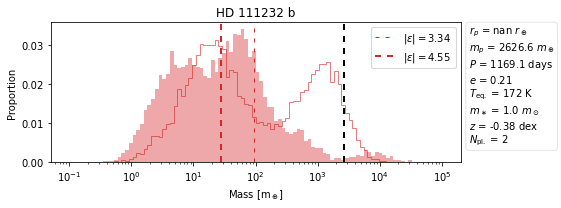

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
true_mass = my_df.iloc[cur_idx]['pl_bmassj'] * MJ
imputed_mass_6params = np.exp(np.mean(knnxkde_samples_6params[(cur_idx, 1)]) * (m2 + 1e-6) + m1) * MJ
eps_6params = np.log(true_mass) - np.log(imputed_mass_6params)
imputed_mass_8params = np.exp(np.mean(knnxkde_samples_8params[(cur_idx, 1)]) * (m2 + 1e-6) + m1) * MJ
eps_8params = np.log(true_mass) - np.log(imputed_mass_8params)

ax.hist(mass_samples_6params, bins=my_mass_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
ax.hist(mass_samples_8params, bins=my_mass_bins, weights=my_weights, color='C3', alpha=0.4)
ax.axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
ax.axvline(imputed_mass_6params, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(eps_6params):.2f}')
ax.axvline(imputed_mass_8params, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_8params):.2f}')
ax.set_xscale('log')
ax.set_xlabel('Mass [m$_\oplus$]')
ax.set_ylabel('Proportion')
ax.legend()

props = dict(boxstyle='round', facecolor='white', alpha=0.1)
ax.text(1.02, 0.98, generate_planet_bio(cur_idx), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

ax.set_title(f"{my_df.iloc[cur_idx]['pl_name']}")
fig.tight_layout()
plt.savefig(f'results_and_figures/2_comp_whole_archive/distrib_transit_8params/_new_{PLANET_NAME}.pdf')
plt.show()

## B. RV Case

In [9]:
DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID = dict()  # name and row id for planets with observed mass AND radius
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]) and ~np.isnan(my_df['pl_radj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASS_AND_RADIUS = len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID)

In [10]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20
imputed_samples = dict()  # will store imputation sample for each planet
N, D = X.shape

In [13]:
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    print(f'{i+1}/{NB_OBSERVED_MASS_AND_RADIUS}... {cur_name}                      ', end='\r')
    if ((i+1)%100)==0:
        print(f'                                           ', end='\r')
        print(f'{i+1}/{NB_OBSERVED_MASS_AND_RADIUS} -> {time.strftime("%H:%M:%S", time.localtime())}')
    miss_data = np.copy(X)
    miss_data[cur_idx, 0] = np.nan  # RV case: hide the radius...
    miss_data[cur_idx, 1] = np.nan  # ... and the mass
    norm_miss_data, norm_params = normalization(miss_data)
    r1 = norm_params['min_val'][0]
    r2 = norm_params['max_val'][0]
    m1 = norm_params['min_val'][1]
    m2 = norm_params['max_val'][1]

    knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
    norm_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000, chosen_subset=[0, 1, 2, 4, 5, 7])
    imputed_samples[(cur_name, 'radius')] = norm_samples[(cur_idx, 0)] * (r2 + 1e-6) + r1
    imputed_samples[(cur_name, 'mass')] = norm_samples[(cur_idx, 1)] * (m2 + 1e-6) + m1

100/1081 -> 10:21:18                                     
200/1081 -> 10:46:54                         
300/1081 -> 11:13:30                           
400/1081 -> 11:41:40                          
500/1081 -> 12:10:03                           
600/1081 -> 12:35:36                          
700/1081 -> 13:01:09                          
800/1081 -> 13:26:43                             
900/1081 -> 13:53:20                              
1000/1081 -> 14:21:40                         


In [14]:
save_dir = f'results_and_figures/2_comp_whole_archive'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
#with open(f'{save_dir}/rv_case_masses_radii_8params_nbn20_subset6.pkl', 'wb') as f:
#    pickle.dump(imputed_samples, f)

Save the samples...  
Reload them for analysis + plotting  
1. Raw results
2. With convolution

In [11]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/rv_case_masses_radii_8params_nbn20_subset6.pkl', 'rb') as f:
    imputed_samples = pickle.load(f)  # Note: samples are in log

In [35]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

rad_distrib_numpy = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
mass_distrib_numpy = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
true_radii_numpy = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
true_masses_numpy = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
mask_tlg2020 = np.zeros(NB_OBSERVED_MASS_AND_RADIUS, dtype='bool')

for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    rad_distrib_numpy[i] = np.exp(imputed_samples[(cur_name, 'radius')])
    mass_distrib_numpy[i] = np.exp(imputed_samples[(cur_name, 'mass')])
    true_radii_numpy[i] = my_df.iloc[cur_idx]['pl_radj']
    true_masses_numpy[i] = my_df.iloc[cur_idx]['pl_bmassj']
    if cur_name in list(test_names):
        mask_tlg2020[i] = True

In [16]:
np.random.seed(666)  # For reproducibility
nb_repeat = 100

rad_estimates = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
mass_estimates = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    rad_estimates[:, n], mass_estimates[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_numpy,
        mass_distrib=mass_distrib_numpy,
        true_masses=true_masses_numpy,
        incl=cur_i,
    )

In [17]:
rad_imputed_values = np.mean(rad_estimates, axis=-1)
mass_imputed_values = np.mean(mass_estimates, axis=-1)

rad_eps1 = np.sqrt(np.mean((np.log(rad_imputed_values) - np.log(true_radii_numpy)) ** 2.0))
rad_eps2 = np.sqrt(np.mean((np.log(rad_imputed_values[mask_tlg2020]) - np.log(true_radii_numpy[mask_tlg2020])) ** 2.0))
mass_eps1 = np.sqrt(np.mean((np.log(mass_imputed_values) - np.log(true_masses_numpy)) ** 2.0))
mass_eps2 = np.sqrt(np.mean((np.log(mass_imputed_values[mask_tlg2020]) - np.log(true_masses_numpy[mask_tlg2020])) ** 2.0))

print(f'Radius ==> Epsilon 1 = {rad_eps1:.4f} | Epsilon 2 = {rad_eps2:.4f}')  # With 6 params: 0.3980 / 0.4056
print(f'Mass ==> Epsilon 1 = {mass_eps1:.4f} | Epsilon 2 = {mass_eps2:.4f}')  # With 6 params: 0.1806 / 0.2411

Radius ==> Epsilon 1 = 0.3630 | Epsilon 2 = 0.3963
Mass ==> Epsilon 1 = 0.1566 | Epsilon 2 = 0.2754


Compute the epsilon over 10 bins

In [18]:
list_thresh = np.geomspace(1e-1, 1e4, num=11)
np_eps_thresh = np.zeros(len(list_thresh)-1)

for n in range(len(list_thresh)-1):
    thresh1 = list_thresh[n]
    thresh2 = list_thresh[n+1]
    mask1 = (true_masses_numpy * MJ) > thresh1
    mask2 = (true_masses_numpy * MJ) < thresh2
    mask = np.logical_and(mask1, mask2)
    print(f"{n} -> {thresh1:.2e} ~ {thresh2:.2e} | Count = {str(np.sum(mask)).rjust(3, ' ')}", end='')
    np_eps_thresh[n] = np.sqrt(np.mean((np.log(true_masses_numpy) - np.log(mass_imputed_values))[mask] ** 2.0))
    print(f'  => Eps = {np_eps_thresh[n]:.4f}')
print(f'Everyone | Count = {true_masses_numpy.shape[0]}', end='')
print(f'  => {np.sqrt(np.mean((np.log(true_masses_numpy) - np.log(mass_imputed_values)) ** 2.0)):.4f}')

0 -> 1.00e-01 ~ 3.16e-01 | Count =   3  => Eps = 0.3817
1 -> 3.16e-01 ~ 1.00e+00 | Count =  15  => Eps = 0.4130
2 -> 1.00e+00 ~ 3.16e+00 | Count =  54  => Eps = 0.1227
3 -> 3.16e+00 ~ 1.00e+01 | Count = 187  => Eps = 0.2901
4 -> 1.00e+01 ~ 3.16e+01 | Count = 164  => Eps = 0.1398
5 -> 3.16e+01 ~ 1.00e+02 | Count = 113  => Eps = 0.0812
6 -> 1.00e+02 ~ 3.16e+02 | Count = 251  => Eps = 0.0445
7 -> 3.16e+02 ~ 1.00e+03 | Count = 205  => Eps = 0.0688
8 -> 1.00e+03 ~ 3.16e+03 | Count =  61  => Eps = 0.0941
9 -> 3.16e+03 ~ 1.00e+04 | Count =  25  => Eps = 0.1286
Everyone | Count = 1081  => 0.1566


Now plot

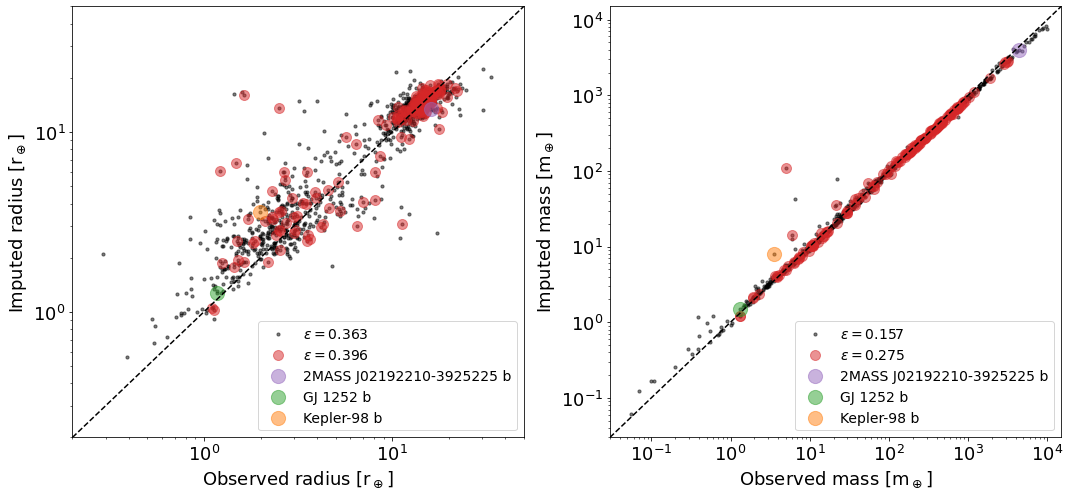

In [20]:
MIN_RAD, MAX_RAD = 2e-1, 5e1  # 4e-1, 5e1
MIN_MASS, MAX_MASS = 3e-2, 1.5e4  # 3e-1, 1.3e4

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
lab_rad1 = f'$\epsilon=${rad_eps1:.3f}'
lab_rad2 = f'$\epsilon=${rad_eps2:.3f}'
lab_mass1 = f'$\epsilon=${mass_eps1:.3f}'
lab_mass2 = f'$\epsilon=${mass_eps2:.3f}'
ax[0].scatter(true_radii_numpy*RJ, rad_imputed_values*RJ, c='black', s=10, alpha=0.5, label=lab_rad1)
ax[0].scatter(true_radii_numpy[mask_tlg2020]*RJ, rad_imputed_values[mask_tlg2020]*RJ, c='C3', s=100, alpha=0.5, label=lab_rad2)
ax[1].scatter(true_masses_numpy*MJ, mass_imputed_values*MJ, c='black', s=10, alpha=0.5, label=lab_mass1)
ax[1].scatter(true_masses_numpy[mask_tlg2020]*MJ, mass_imputed_values[mask_tlg2020]*MJ, c='C3', s=100, alpha=0.5, label=lab_mass2)

idx1, idx2, idx3 = 0, 51, 683  # 2MASS J02192210-3925225 b (TAIL), GJ 1252 b (TWO MODES), Kepler-98 b (BAD)
label1 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx2]
label3 = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx3]
ax[0].scatter(true_radii_numpy[idx1]*RJ, rad_imputed_values[idx1]*RJ, c='C4', s=200, alpha=0.5, label=label1)
ax[0].scatter(true_radii_numpy[idx2]*RJ, rad_imputed_values[idx2]*RJ, c='C2', s=200, alpha=0.5, label=label2)
ax[0].scatter(true_radii_numpy[idx3]*RJ, rad_imputed_values[idx3]*RJ, c='C1', s=200, alpha=0.5, label=label3)
ax[1].scatter(true_masses_numpy[idx1]*MJ, mass_imputed_values[idx1]*MJ, c='C4', s=200, alpha=0.5, label=label1)
ax[1].scatter(true_masses_numpy[idx2]*MJ, mass_imputed_values[idx2]*MJ, c='C2', s=200, alpha=0.5, label=label2)
ax[1].scatter(true_masses_numpy[idx3]*MJ, mass_imputed_values[idx3]*MJ, c='C1', s=200, alpha=0.5, label=label3)

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].tick_params(axis='both', which='major', labelsize=18)
    ax[i].legend(fontsize=14, loc='lower right')
ax[0].set_xlabel('Observed radius [r$_\oplus$]', size=18)
ax[0].set_ylabel('Imputed radius [r$_\oplus$]', size=18)
ax[0].plot([MIN_RAD, MAX_RAD], [MIN_RAD, MAX_RAD], 'k--')
ax[0].set_xlim(MIN_RAD, MAX_RAD)
ax[0].set_ylim(MIN_RAD, MAX_RAD)
ax[1].set_xlabel('Observed mass [m$_\oplus$]', size=18)
ax[1].set_ylabel('Imputed mass [m$_\oplus$]', size=18)
ax[1].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax[1].set_xlim(MIN_MASS, MAX_MASS)
ax[1].set_ylim(MIN_MASS, MAX_MASS)

fig.tight_layout()
plt.savefig('results_and_figures/2_comp_whole_archive/rv_convolution_8params_nbn20_subset6.pdf')
plt.show()

### Plotting few distributions for the RV case: compare 6 params and 8 params

In [17]:
save_dir = f'results_and_figures/2_comp_whole_archive'

with open(f'{save_dir}/rv_case_masses_radii.pkl', 'rb') as f:
    imputed_samples_6params = pickle.load(f)  # Note: samples are in log

with open(f'{save_dir}/rv_case_masses_radii_8params_nbn20_subset6.pkl', 'rb') as f:
    imputed_samples_8params = pickle.load(f)  # Note: samples are in log

In [18]:
rad_distrib_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
mass_distrib_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
rad_distrib_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
mass_distrib_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
true_radii = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
true_masses = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
mask_tlg2020 = np.zeros(NB_OBSERVED_MASS_AND_RADIUS, dtype='bool')

for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    rad_distrib_6params[i] = np.exp(imputed_samples_6params[(cur_name, 'radius')])
    mass_distrib_6params[i] = np.exp(imputed_samples_6params[(cur_name, 'mass')])
    rad_distrib_8params[i] = np.exp(imputed_samples_8params[(cur_name, 'radius')])
    mass_distrib_8params[i] = np.exp(imputed_samples_8params[(cur_name, 'mass')])
    true_radii[i] = my_df.iloc[cur_idx]['pl_radj']
    true_masses[i] = my_df.iloc[cur_idx]['pl_bmassj']
    if cur_name in list(test_names):
        mask_tlg2020[i] = True

In [19]:
np.random.seed(666)  # For reproducibility
nb_repeat = 100

rad_estimates_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
mass_estimates_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
rad_estimates_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
mass_estimates_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    rad_estimates_6params[:, n], mass_estimates_6params[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib = rad_distrib_6params,
        mass_distrib = mass_distrib_6params,
        true_masses = true_masses,
        incl=cur_i,
    )
    rad_estimates_8params[:, n], mass_estimates_8params[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib = rad_distrib_8params,
        mass_distrib = mass_distrib_8params,
        true_masses = true_masses,
        incl=cur_i,
    )

In [20]:
rad_imputed_values_6params = np.mean(rad_estimates_6params, axis=-1)
mass_imputed_values_6params = np.mean(mass_estimates_6params, axis=-1)
rad_imputed_values_8params = np.mean(rad_estimates_8params, axis=-1)
mass_imputed_values_8params = np.mean(mass_estimates_8params, axis=-1)

rad_eps1_6params = np.sqrt(np.mean((np.log(rad_imputed_values_6params) - np.log(true_radii)) ** 2.0))
rad_eps2_6params = np.sqrt(np.mean((np.log(rad_imputed_values_6params[mask_tlg2020]) - np.log(true_radii[mask_tlg2020])) ** 2.0))
mass_eps1_6params = np.sqrt(np.mean((np.log(mass_imputed_values_6params) - np.log(true_masses)) ** 2.0))
mass_eps2_6params = np.sqrt(np.mean((np.log(mass_imputed_values_6params[mask_tlg2020]) - np.log(true_masses[mask_tlg2020])) ** 2.0))

print('== 6 PARAMS ==')
print(f'Radius ==> Epsilon 1 = {rad_eps1_6params:.4f} | Epsilon 2 = {rad_eps2_6params:.4f}')
print(f'Mass ==> Epsilon 1 = {mass_eps1_6params:.4f} | Epsilon 2 = {mass_eps2_6params:.4f}')

rad_eps1_8params = np.sqrt(np.mean((np.log(rad_imputed_values_8params) - np.log(true_radii)) ** 2.0))
rad_eps2_8params = np.sqrt(np.mean((np.log(rad_imputed_values_8params[mask_tlg2020]) - np.log(true_radii[mask_tlg2020])) ** 2.0))
mass_eps1_8params = np.sqrt(np.mean((np.log(mass_imputed_values_8params) - np.log(true_masses)) ** 2.0))
mass_eps2_8params = np.sqrt(np.mean((np.log(mass_imputed_values_8params[mask_tlg2020]) - np.log(true_masses[mask_tlg2020])) ** 2.0))

print('== 8 PARAMS ==')
print(f'Radius ==> Epsilon 1 = {rad_eps1_8params:.4f} | Epsilon 2 = {rad_eps2_8params:.4f}')
print(f'Mass ==> Epsilon 1 = {mass_eps1_8params:.4f} | Epsilon 2 = {mass_eps2_8params:.4f}')

== 6 PARAMS ==
Radius ==> Epsilon 1 = 0.3980 | Epsilon 2 = 0.4056
Mass ==> Epsilon 1 = 0.1806 | Epsilon 2 = 0.2411
== 8 PARAMS ==
Radius ==> Epsilon 1 = 0.3630 | Epsilon 2 = 0.3963
Mass ==> Epsilon 1 = 0.1566 | Epsilon 2 = 0.2754


In [21]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
my_rad_bins = np.geomspace(1e-1, 1e2, num=101)
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights = np.ones(mass_distrib_6params.shape[1]) / mass_distrib_6params.shape[1]

In [22]:
PLANET_NAME = 'K2-111 b'
cur_idx = np.where(my_df['pl_name'] == PLANET_NAME)[0][0]
i = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID).index(PLANET_NAME)

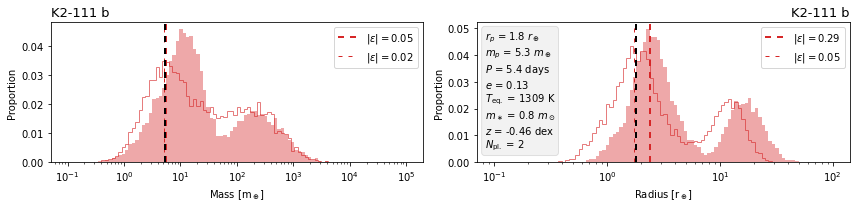

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].hist(mass_distrib_8params[i]*MJ, bins=my_mass_bins, weights=my_weights, color='C3', alpha=0.4)
ax[0].hist(mass_distrib_6params[i]*MJ, bins=my_mass_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
mass_eps_8params = np.log(mass_imputed_values_8params[i]) - np.log(true_masses[i])
mass_eps_6params = np.log(mass_imputed_values_6params[i]) - np.log(true_masses[i])
ax[0].axvline(mass_imputed_values_8params[i]*MJ, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(mass_eps_8params):.2f}')
ax[0].axvline(mass_imputed_values_6params[i]*MJ, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(mass_eps_6params):.2f}')
ax[0].axvline(true_masses[i]*MJ, ls=(0, (3, 3)), c='black', lw=2)
ax[0].set_xscale('log')
ax[0].set_xlabel('Mass [m$_\oplus$]')
ax[0].set_ylabel('Proportion')
ax[0].legend()

ax[1].hist(rad_distrib_8params[i]*RJ, bins=my_rad_bins, weights=my_weights, color='C3', alpha=0.4)
ax[1].hist(rad_distrib_6params[i]*RJ, bins=my_rad_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
rad_eps_8params = np.log(rad_imputed_values_8params[i]) - np.log(true_radii[i])
rad_eps_6params = np.log(rad_imputed_values_6params[i]) - np.log(true_radii[i])
ax[1].axvline(rad_imputed_values_8params[i]*RJ, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(rad_eps_8params):.2f}')
ax[1].axvline(rad_imputed_values_6params[i]*RJ, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(rad_eps_6params):.2f}')
ax[1].axvline(true_radii[i]*RJ, ls=(0, (3, 3)), c='black', lw=2)
ax[1].set_xscale('log')
ax[1].set_xlabel('Radius [r$_\oplus$]')
ax[1].set_ylabel('Proportion')
ax[1].legend()

props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
ax[1].text(0.02, 0.95, generate_planet_bio(cur_idx), transform=ax[1].transAxes, fontsize=10, verticalalignment='top', bbox=props)
ax[0].set_title(my_df.iloc[cur_idx]['pl_name'], loc='left', size=13)
ax[1].set_title(my_df.iloc[cur_idx]['pl_name'], loc='right', size=13)
fig.tight_layout()
plt.savefig(f'results_and_figures/2_comp_whole_archive/distrib_6vs8params/{PLANET_NAME}.pdf')
plt.show()